## Importing libraries

This MLP network is created from scratch using only the numpy library. It focuses on introductory algorithms and techniques, making numpy the sole necessary library. This minimalist approach highlights the fundamental concepts of neural networks while relying on numpy's powerful numerical computations for essential operations.


In [3]:
import sys
sys.path.insert(0, '../helper')
import mnist_loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import metrics
from sklearn.linear_model import Perceptron

## Activation Functions Class

In [34]:
class Activation:
  """
    - Activation functions.
    - And their derivatives
  """

  @classmethod
  def sigmoid(cls, vec):
    """
      Sigmoid activation function.
    """
    return 1.0 / (1.0 + np.exp(-vec))

  @classmethod
  def sigmoid_drv(cls, vec):
    """
      Sigmoid function derivative.
    """
    return cls.sigmoid(vec) * (1 - cls.sigmoid(vec))

  @classmethod
  def step(cls, vec):
    """
      Binary Step activation function.
    """
    return np.where(vec > 0, 1, 0)

  @classmethod
  def relu(cls, vec):
    """
      Rectified Linear Unit
    """
    return np.maximum(0, vec)

  @classmethod
  def relu_drv(cls, vec):
    """
      Rectified Linear Unit Derivative
    """
    return np.where(vec > 0, 1, 0)

  @classmethod
  def tanh(cls, vec):
    """
      Hiperbolic Tangent
    """
    return np.tanh(vec)

  @classmethod
  def tanh_drv(cls, vec):
    """
      Hiperbolic Tangent Derivative
    """
    return 1 - np.tanh(vec)**2

## Cost Function Class

In [35]:
class Cost:
  """
    - Cost functions.
  """

  @classmethod
  def cost_derivative(cls, output_activations, y):
    """
      - Return the vector of partial derivatives partial C(x).
      - Partial a for the output activations.
    """
    return (output_activations-y)

  @classmethod
  def mean_squared_error(cls, output, target):
    """
    Calculates the mean squared error between the output and the target.

    :param output: The output of the network.
    :param target: The desired output.
    :return: The mean squared error.
    """
    diff = output - target
    differences_squared = 0.5 *(diff ** 2)
    mean_diff = differences_squared.mean()

    return mean_diff

## Network Object

In [36]:
class Network:
  """
    - A Feed Foward Neural Network.
    - Uses Stochastic Gradient Descent learning algorithm.
    - Gradients are being caculated using back propagation.
    - Misses some optimizations and omits some desirable features.
  """
  def __init__(self, sizes, activation_function = Activation.sigmoid, actv_drv = Activation.sigmoid_drv):
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    self.activation_function = activation_function
    self.actv_drv = actv_drv

  def feed_foward(self, a):
    """
      Calculates the final result of a input going through the NN.
    """
    for b, w in zip(self.biases, self.weights):
      a = self.activation_function(np.dot(w, a) + b)
    return a

  def update_mini_batch(self,  mini_batch, eta):
    """
      - Updates the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
      - The "mini_batch" is a list of tuples "(x, y)".
      - "eta is the learning rate.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # Nabla lists are lists of numpy arrays, in the same way as self.weights and self.biases
    # They store, by adding, all the changes in the weights calculated by the back propagation algorithm
    for x, y in mini_batch:
      delta_nabla_b, delta_nabla_w = self.back_propagation(x, y)

      nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    # Recalculate weights for a mini-batch run
    self.weights = [w - (eta/len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b - (eta/len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
    """
      - Utilizes mini-batch stochastic gradient descent for training the neural network.
      - The "training_data" consists of tuples "(x, y)" representing input and desired output.
      - Other parameters are self-explanatory.
      - If "test_data" is provided, the network evaluates against it after each epoch, allowing for progress tracking but at a slower pace.
    """

    if test_data:
      test_data = list(test_data)
      n_test = len(test_data)

    training_data = list(training_data)
    n = len(training_data)

    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]

      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch, eta)

      if test_data :
        print(f"Epoch {j}: {self.evaluate(test_data, n_test)}")
        print(f"Loss: {self.calculate_loss(test_data, n_test)}")

      else:
        print(f"Epoch {j}: complete")


  def back_propagation(self, x, y):
    """
      - Returns a tuple "(nabla_b, nabla_w)" representing the gradient for the chosen Cost Function C(x).
      - "nabla_b" & "nabla_w" are layer-by-layer lists of numpy arrays.
      - Similar to "self.biases" and "self.weights".
      - How much is the adjustment.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # Feed-foward phase

    activation = x
    activations = [x] # Stores activations layer by layer
    zs = [] # Stores all the z vectores, layer-by-layer

    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation) + b
      zs.append(z)
      activation = self.activation_function(z)
      activations.append(activation)

    # Backward pass -> delta rule
    delta = Cost.cost_derivative(activations[-1], y) * self.actv_drv(zs[-1])

    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    # In the following loop we want to iterate from the last to the first layer, excluding the output and the input layers
    # We are taking advantage that python can use negative indices

    for l in range(2, self.num_layers):
      z = zs[-l]
      sig_dv = self.actv_drv(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sig_dv
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

    return (nabla_b, nabla_w)


  def evaluate(self, test_data, len_test_data):
    """
      - Evaluates the number of correct predictions of the NN.
      - The output is chosen by the "winner takes all" rule, where the highest number on the output vector is the prediction
    """
    test_results = [(np.argmax(self.feed_foward(x)), y) for (x, y) in test_data]

    return sum (int(x == y) for (x, y) in test_results) / len_test_data

  def calculate_loss(self, test_data, len_test_data, cost_function=Cost.mean_squared_error):
          """
          Calculates the loss for a given dataset using the specified cost function.

          :param data: A list of tuples "(x, y)" representing input and desired output.
          :param cost_function: The cost function to calculate the loss (default: mean squared error).
          :return: The calculated loss.
          """
          test_data = list(test_data)
          loss = 0.0
          for x, y in test_data:
              output = self.feed_foward(x)
              prediction = np.argmax(output)
              loss += cost_function(prediction, y)
          return loss / len_test_data


  def debug(self):
    """
      - Write any code for debbuging.
    """

## Training

In this section we're going to train this simple Mlp using the mnist dataset in the ".pkl" file, using its default data division.

## Tuning

Now, we're going to explore the hyperparameters of this MLP, in order to find the most adequate configuration for it.

### Activation Function

#### Sigmoid Function

The sigmoid function yielded the best results so far. When we used the same parameter values for all the functions, the sigmoid function achieved an accuracy of over 90%, while the other functions only reached around 10%-20% accuracy. Therefore, it's clear that the sigmoid function outperformed the others in terms of accuracy. The behaviour of the net while using the sigmoid function is much more desirable, the tendency of it its to keep improving its perfomance.

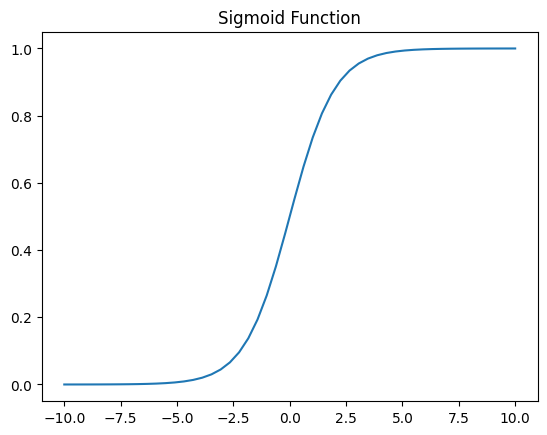

In [26]:
x = np.linspace(-10, 10)
y = Activation.sigmoid(x)

plt.plot(x, y)
plt.title("Sigmoid Function")
plt.show()

In [27]:
net = Network([784, 30, 10])
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

#epochs, mini_batch_size, eta,
net.SGD(training_data, 30, 10, 4.0, test_data=test_data)

Epoch 0: 0.8034 / 10000
Loss: 2.55155
Epoch 1: 0.8122 / 10000
Loss: 1.77595
Epoch 2: 0.8223 / 10000
Loss: 1.7472
Epoch 3: 0.8286 / 10000
Loss: 2.00105
Epoch 4: 0.8275 / 10000
Loss: 1.7882
Epoch 5: 0.8305 / 10000
Loss: 2.1583
Epoch 6: 0.8276 / 10000
Loss: 1.6067
Epoch 7: 0.8356 / 10000
Loss: 1.47985
Epoch 8: 0.8354 / 10000
Loss: 2.10625
Epoch 9: 0.8356 / 10000
Loss: 1.81675
Epoch 10: 0.8365 / 10000
Loss: 2.38035
Epoch 11: 0.8372 / 10000
Loss: 2.26865
Epoch 12: 0.8412 / 10000
Loss: 1.9853
Epoch 13: 0.8375 / 10000
Loss: 1.42935
Epoch 14: 0.8408 / 10000
Loss: 2.0269
Epoch 15: 0.8397 / 10000
Loss: 2.109
Epoch 16: 0.841 / 10000
Loss: 2.0056
Epoch 17: 0.8405 / 10000
Loss: 1.69735
Epoch 18: 0.843 / 10000
Loss: 2.11205
Epoch 19: 0.8431 / 10000
Loss: 1.744
Epoch 20: 0.8441 / 10000
Loss: 1.83985
Epoch 21: 0.8431 / 10000
Loss: 2.05525
Epoch 22: 0.8419 / 10000
Loss: 2.1096
Epoch 23: 0.8475 / 10000
Loss: 1.5096
Epoch 24: 0.8503 / 10000
Loss: 2.03265
Epoch 25: 0.8626 / 10000
Loss: 2.21905
Epoch 26: 0

#### Tanh Function


The hyperbolic tangent (tanh) function didn't give us good results. We used the same parameters as before when we were using the sigmoid function, but the tanh function didn't work well in this case. Initially, the accuracy improved in the first 5-7 epochs, but after that, the performance of the network either stayed the same or got worse. Overall, the tanh function didn't perform well.

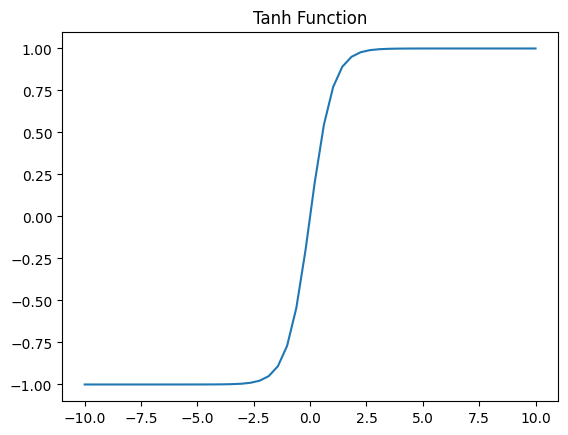

In [28]:
x = np.linspace(-10, 10)
y = Activation.tanh(x)

plt.plot(x, y)
plt.title("Tanh Function")
plt.show()

In [29]:
net = Network([784, 30, 10], Activation.tanh, Activation.tanh_drv)
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

#epochs, mini_batch_size, eta,
net.SGD(training_data, 30, 10, 4.0, test_data=test_data)

Epoch 0: 0.098 / 10000
Loss: 14.0556
Epoch 1: 0.0984 / 10000
Loss: 14.0264
Epoch 2: 0.0984 / 10000
Loss: 14.0256
Epoch 3: 0.0984 / 10000
Loss: 14.0256
Epoch 4: 0.0984 / 10000
Loss: 14.02705
Epoch 5: 0.0984 / 10000
Loss: 14.02645
Epoch 6: 0.0984 / 10000
Loss: 14.02645
Epoch 7: 0.0984 / 10000
Loss: 14.02645
Epoch 8: 0.0984 / 10000
Loss: 14.0245
Epoch 9: 0.0984 / 10000
Loss: 14.02485
Epoch 10: 0.0984 / 10000
Loss: 14.02665
Epoch 11: 0.0984 / 10000
Loss: 14.02665
Epoch 12: 0.0984 / 10000
Loss: 14.02665
Epoch 13: 0.0984 / 10000
Loss: 14.0263
Epoch 14: 0.0984 / 10000
Loss: 14.0263
Epoch 15: 0.0984 / 10000
Loss: 14.0263
Epoch 16: 0.0984 / 10000
Loss: 14.0263
Epoch 17: 0.0984 / 10000
Loss: 14.04175
Epoch 18: 0.0984 / 10000
Loss: 14.02065
Epoch 19: 0.0984 / 10000
Loss: 14.0278
Epoch 20: 0.098 / 10000
Loss: 14.06435
Epoch 21: 0.098 / 10000
Loss: 14.06435
Epoch 22: 0.098 / 10000
Loss: 14.06435
Epoch 23: 0.098 / 10000
Loss: 14.06435
Epoch 24: 0.098 / 10000
Loss: 14.06435
Epoch 25: 0.098 / 10000
Lo

### ETA - learning rate

In this section we've decided to follow a common approach, keep increasing the learning rate untill the model's accuracy starts to go down, so that we can have the most apropriate learning rate for the problem.

For the matter of the comparison, we've reduced the number of epochs, so that the training process could become quicker, but it still took a long time to bring the results up.

Was you'll see in the graph above, the most adequate learing rate was aroud 6, as we increase the ETA the accuracy decreases very abruptaly.

#### From 0.1-0.9

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoc

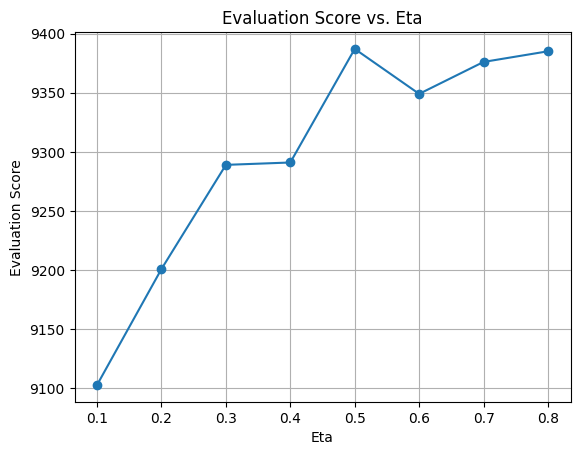

In [16]:
res = []
etas = [eta / 10 for eta in range(1, 10)]  # Learning rates
losses = []

for index, eta in enumerate(etas):
  print(f"\nTraining {index+1}, using eta: {eta}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, res, marker='o')
plt.xlabel('Eta')
plt.ylabel('Evaluation Score')
plt.title('Evaluation Score vs. Eta')
plt.grid(True)
plt.show()

#### From 1-9

Training 0, using eta: 1

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Training 1, using eta: 2

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Training 2, using eta: 3

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Ep

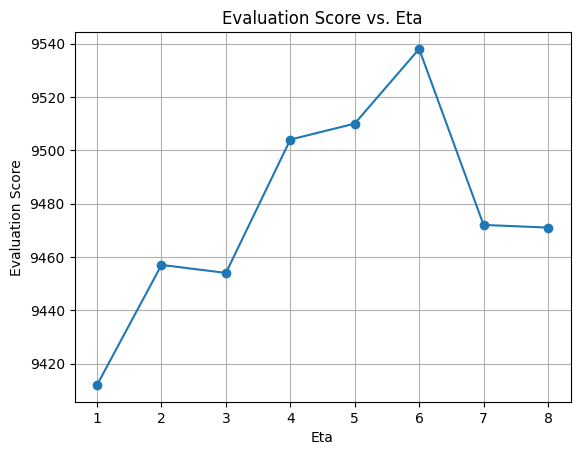

In [17]:
res = []
etas = [eta for eta in range(1, 10)]  # Learning rates
losses = []
for index, eta in enumerate(etas):
  print(f"\nTraining {index+1}, using eta: {eta}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, res, marker='o')
plt.xlabel('Eta')
plt.ylabel('Evaluation Score')
plt.title('Evaluation Score vs. Eta')
plt.grid(True)
plt.show()

#### From 6-6.9

In this test we can see a very curious case, in which the loss goes very high up when the learning rate is set to 6.7


Training 1, using eta: 6.0

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete

Training 2, using eta: 6.1

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete

Training 3, using eta: 6.2

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: co

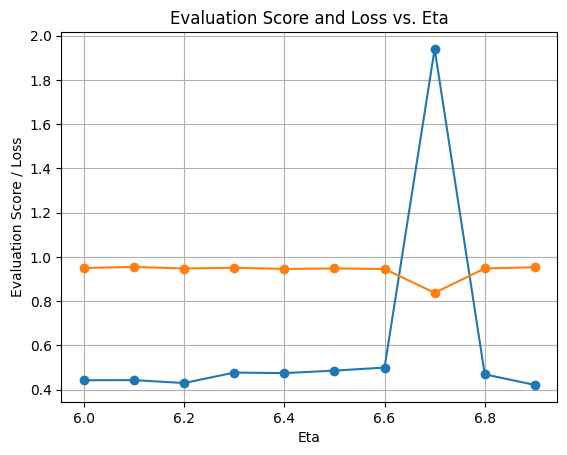

In [38]:
res = []
etas = [eta/10 for eta in range(60, 70)]  # Learning rates
losses = []

for index, eta in enumerate(etas):
  print(f"\nTraining {index+1}, using eta: {eta}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, losses, marker='o', label='Loss')  # Plotting the loss line graph
plt.plot(etas, res, marker='o', label='Evaluation Score')  # Plotting the evaluation score line graph
plt.xlabel('Eta')
plt.ylabel('Evaluation Score / Loss')
plt.title('Evaluation Score and Loss vs. Eta')
plt.grid(True)

### Mini batch size

In [ ]:
res = []
mini_batch_sizes = [sz for sz in range(2, 30, 2)]  # Mini batch size
losses = []

for index, sz in enumerate(mini_batch_sizes):
  print(f"\nTraining {index+1}, using eta: {sz}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, res, marker='o')
plt.xlabel('Eta')
plt.ylabel('Evaluation Score')
plt.title('Evaluation Score vs. Eta')
plt.grid(True)
plt.show()

### Number of Epochs

### Regularization / Droup-out

### The network architecture

### Machine Learning Algorithm